<a href="https://colab.research.google.com/github/PtrShi/cvr_course/blob/main/notebooks/cv_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [1]:
!git clone https://github.com/PtrShi/cvr_course.git
#%cd "cvr_course/notebooks"
#!ls

Cloning into 'cvr_course'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 249 (delta 54), reused 0 (delta 0), pack-reused 167
Receiving objects: 100% (249/249), 48.92 MiB | 32.07 MiB/s, done.
Resolving deltas: 100% (90/90), done.


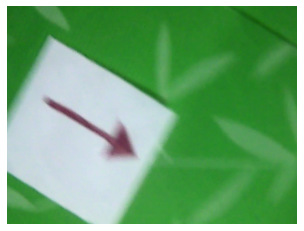

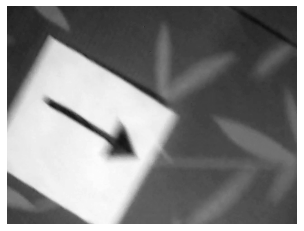

In [94]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
#plt.rcParams["figure.figsize"] = (10,10)
imgdir = 'cvr_course/data/imgs/arrow/'
#filename = 'vlcsnap-2020-10-21-18h01m22s212.png'
#filename = 'vlcsnap-2020-10-21-18h01m27s294.png'
#filename = 'vlcsnap-2020-10-21-18h01m29s941.png'
#filename = 'vlcsnap-2020-10-21-18h01m33s362.png'
#filename = 'vlcsnap-2020-10-21-18h01m36s056.png'
#filename = 'vlcsnap-2020-10-21-18h01m41s874.png'
#filename = 'vlcsnap-2020-10-21-18h01m44s163.png'
#filename = 'vlcsnap-2020-10-21-18h01m46s644.png'
#filename = 'vlcsnap-2020-10-21-18h01m49s487.png'
filename = 'vlcsnap-2020-10-21-18h01m51s638.png'
img_orig = cv2.imread (imgdir + filename, cv2.IMREAD_COLOR)
if img_orig is None:
  assert False, 'no such a file'
plt.imshow (img_orig)  
plt.axis ('off')
plt.show ()
img_bw = cv2.cvtColor (img_orig, cv2.COLOR_BGR2GRAY)
plt.imshow (img_bw, cmap = 'gray')
plt.axis ('off')
plt.show ()

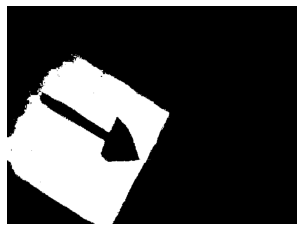

In [95]:
# Mask
low_th  = (210) #, 200, 200)  # Надо менять в зависимости от картинки
high_th = (255) #, 255, 255)

mask = cv2.inRange (img_bw, low_th, high_th)

# ker_sz = 3
# kernel = np.ones ((ker_sz, ker_sz), np.uint8)
# mask = cv2.dilate (mask, kernel, iterations = 1)  

plt.imshow (mask, cmap = 'gray')
plt.axis ('off')
plt.show ()

np.shape (cnt) = (795, 1, 2)


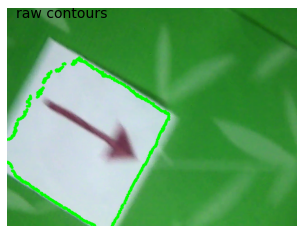

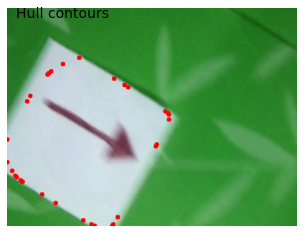

np.shape (vertices) = (4, 1, 2)


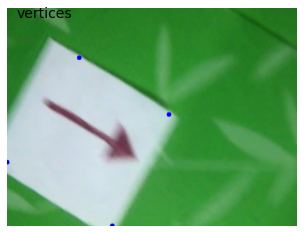

In [96]:
# ищем контуры
contours, _ = cv2.findContours (mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# let's find the largest contour
j = 1 
ind_largest_cont = 0 
# I'm not so good with python magic
while j < len (contours):
  if len (contours [j]) > len (contours [ind_largest_cont]):
    ind_largest_cont = j
  j = j + 1

cnt = contours [ind_largest_cont]
print ('np.shape (cnt) = ' + str (np.shape (cnt)))

cnt_img = cv2.drawContours (img_orig.copy (), cnt, -1, (0, 255, 0), 5)
plt.imshow (cnt_img)
plt.text (20, 20, 'raw contours', fontsize=14)
plt.axis ('off')
plt.show ()

cnt_hull = cv2.convexHull (cnt)
cnt_hull_img = cv2.drawContours (img_orig.copy (), cnt_hull, -1, (255, 0, 0), 10)
# print (np.shape (contours))
# print (np.shape (cnt))
# print (contours)
# print (np.shape (cnt))
# print (np.shape (cnt_hull))
plt.imshow (cnt_hull_img)
plt.text (20, 20, 'Hull contours', fontsize=14)
plt.axis ('off')
plt.show ()

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html
# epsilon - это минимальное расстояние, а не мелкость разбиения (я так понимаю, что объяснение epsilon на семинаре ошибочно)
epsilon = 0.05 * cv2.arcLength (cnt_hull, True)
vertices = cv2.approxPolyDP (cnt_hull, epsilon, True)
# два вечера убил, что бы понять, что cv2.drawContours не рисует контур, а отображает только точки, не соединяя их
print ('np.shape (vertices) = ' + str (np.shape (vertices)))
vertices_img = cv2.drawContours (img_orig.copy (), vertices, -1, (0, 0, 255), 10)
plt.imshow (vertices_img)
plt.text (20, 20, 'vertices', fontsize=14)
plt.axis ('off')
plt.show ()

In [97]:
def order_points(pts):
# Семинарская реализация неверна
# Взял отсюда (центр ищется тоже неправильно)
# только для выпуклых, сортировка по углу относительно орта (0;1) против часовой, начиная с III квадранта -Pi/2
# https://stackoverflow.com/questions/62295185/warping-a-license-plate-image-to-be-frontal-parallel    

    # Step 1: Find centre of object
    center_X, center_Y = np.mean(pts[:,0]) , np.mean(pts[:,1])
    center = (center_X, center_Y)
    print ('center coord')
    print (center_X, center_Y)
    # Step 2: Move coordinate system to centre of object
    shifted = pts - center

    # Step #3: Find angles subtended from centroid to each corner point
    theta = np.arctan2 (shifted[:, 1], shifted[:, 0])
    tan = (shifted[:, 1]/ shifted[:, 0])
    print ('shifted coord respect to the center of the object')
    print (shifted)
    print ('tangent')
    print (tan)
    print ('angles (rad) from III quadrant starting with -Pi/2 to II quadrant ending with Pi/2')
    print (theta)
    # Step #4: Return vertices ordered by theta
    ind = np.argsort(theta)
    ordered = np.array (pts[ind], dtype = 'float32')

    (tl, tr, br, bl) = ordered
# Ищем максимальную длину и ширину листка на картинке, их возьмём за размер выпрямленного изображения
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    x = int (max(widthA, widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    y = int (max(heightA, heightB))
   
    return ordered, (x, y)

In [98]:
# https://stackoverflow.com/questions/62834517/how-to-read-the-result-of-cv2-findcontours
# см комментарии к ответу
vertices_norm = vertices [:,0,:]
print ('vertices coords')
print (vertices_norm)
rect, unwarped_size = order_points (vertices_norm)
print ('ordered rect')
print (rect)
print ('unwarped sheet size will be')
print (unwarped_size)

vertices coords
[[357 234]
 [232 479]
 [  0 339]
 [159 109]]
center coord
187.0 290.25
shifted coord respect to the center of the object
[[ 170.    -56.25]
 [  45.    188.75]
 [-187.     48.75]
 [ -28.   -181.25]]
tangent
[-0.33088235  4.19444444 -0.26069519  6.47321429]
angles (rad) from III quadrant starting with -Pi/2 to II quadrant ending with Pi/2
[-0.31954305  1.33675473  2.88657354 -1.72406748]
ordered rect
[[159. 109.]
 [357. 234.]
 [232. 479.]
 [  0. 339.]]
unwarped sheet size will be
(270, 279)


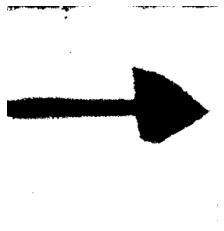

In [99]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
dst = np.array([[0, 0], [unwarped_size[0], 0], [unwarped_size[0], unwarped_size[1]], [0, unwarped_size[1]]], dtype="float32")
mx = cv2.getPerspectiveTransform (rect, dst) 
mask_unwarped = cv2.warpPerspective (mask, mx, unwarped_size)
#mask_unwarped = cv2.warpPerspective (img_orig, mx, unwarped_size)
plt.imshow (mask_unwarped, cmap= 'gray')  
plt.axis ('off')
plt.show ()


box_x, box_y, box_w, box_h =  0 70 253 100
cx, cy =  126 120
1154
2984
3685
2076


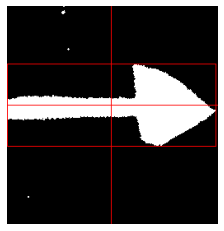

In [100]:
#let's crop a bit
crop_x, crop_y = 7, 7

mask_unwarped_cropped = mask_unwarped [crop_y:-crop_y, crop_x:-crop_x]

# инвертируем изображение
white = np.full ((mask_unwarped_cropped.shape [0], mask_unwarped_cropped.shape [1]), 255)
mask_unwarped_cropped = white - mask_unwarped_cropped
mask_unwarped_cropped = cv2.inRange (mask_unwarped_cropped, 1, 255)

# print (mask_unwarped_cropped.shape [0])
# print (mask_unwarped_cropped.shape [1])
# plt.imshow (mask_unwarped_cropped, cmap = 'gray')  
# plt.axis ('off')
# plt.show ()

# ищем контуры стрелки
contours_unwarped, _ = cv2.findContours (mask_unwarped_cropped, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# let's find the largest contour
j = 1 
ind_largest_cont = 0 
# I'm not so good with python magic
while j < len (contours_unwarped):
  if len (contours_unwarped [j]) > len (contours_unwarped [ind_largest_cont]):
    ind_largest_cont = j
  j = j + 1

cnt_arrow = contours_unwarped [ind_largest_cont]
# print ('np.shape (cnt_arrow) = ' + str (np.shape (cnt_arrow)))

# найдём геометрический центр стрелки
box_x, box_y, box_w, box_h = cv2.boundingRect (cnt_arrow)

cx = int (box_x + box_w / 2)
cy = int (box_y + box_h / 2)

# покрасим для визуализации
mask_color_orig = cv2.cvtColor (mask_unwarped_cropped, cv2.COLOR_GRAY2BGR)
mask_color = mask_color_orig.copy ()

# обведём стрелку прямоугольником и разделим на 4 части через центр
cv2.rectangle (mask_color, (box_x, box_y), (box_x + box_w, box_y + box_h), (255, 0, 0), 1)
cv2.line (mask_color, (cx,0), (cx, mask_unwarped_cropped.shape[0] - 1), (255,0,0), 1)
cv2.line (mask_color, (0,cy), (mask_unwarped_cropped.shape[1] - 1, cy), (255,0,0), 1)

print ('box_x, box_y, box_w, box_h = ', box_x, box_y, box_w, box_h)
print ('cx, cy = ', cx, cy)
#np.set_printoptions(threshold=1000)
#print (mask_color [68:78][60:70][:].shape)
# посчитаем количество белых точек в каждой четверти
weight_tl = np.count_nonzero (mask_unwarped_cropped [box_y:cy, box_x:cx])
weight_tr = np.count_nonzero (mask_unwarped_cropped [box_y:cy, cx:cx + int (box_w/2)])
weight_br = np.count_nonzero (mask_unwarped_cropped [cy: cy + int (box_h/2), cx:cx + int (box_w/2)])
weight_bl = np.count_nonzero (mask_unwarped_cropped [cy: cy + int (box_h/2), box_x:cx])
print (weight_tl)
print (weight_tr)
print (weight_br)
print (weight_bl)
# отсортируем четверти по количеству белых точек
#  0 1
#  2 3                    
weights = np.array ((weight_tl, weight_tr, weight_bl, weight_br), dtype = 'int')
first, second = np.argsort (-weights) [:2]
summa = first + second
if summa == 1:
  direction = 'up'
else:
  if summa == 4:
    direction = 'right'
  else:
    if summa == 5:
      direction = 'down'
    else:
      if summa == 2:
        direction = 'left'
      else:
        direction = 'unknown'
#print (direction)
# print (first, second)
# weights_ordered = weights [np.argsort (-weights)]
# print (weights_ordered)
#print (cx, cy)
#print (mask_unwarped_cropped.shape)
plt.imshow (mask_color)
plt.axis ('off')
plt.show ()

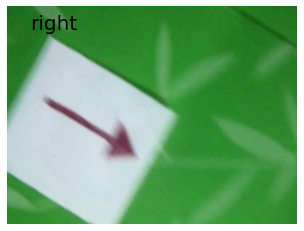

In [101]:
plt.imshow (img_orig)
plt.text (50, 50, direction, fontsize=20)
plt.axis ('off')
plt.show ()